# Laporan Uji Coba Praktikum - Wumpus Truth Table Enumeration
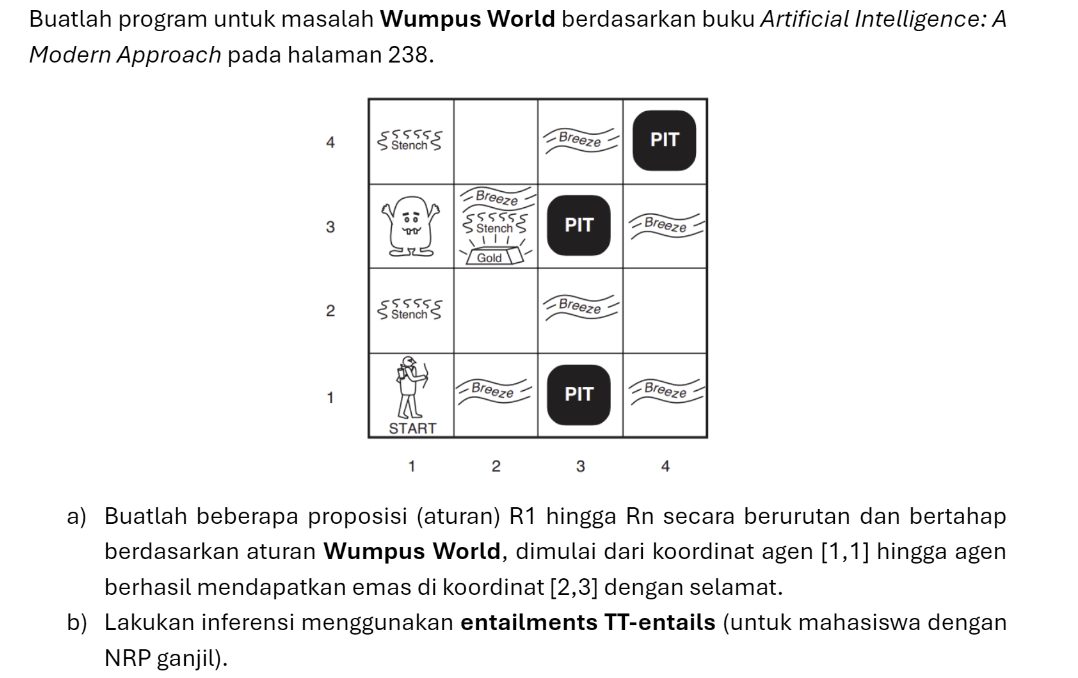

Name    : Abdan Hafidz
NRP     : 5054231021


## Importing Libraries

In [94]:
from utils import *
from logic import *
from notebook import psource
import agents as a
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Defining Symbols
First we define a proposition 

- B<sub>(i j)</sub> states that there is a breeze in plot (i,j) 

- P<sub>(i j)</sub> states that there is a Pit in plot (i,j)

- S<sub>(i j)</sub> states that there is a Stench in plot (i,j)

- W<sub>(i j)</sub> states that there is a Wumpus in plot (i,j)

- G<sub>(i j)</sub> states that there is Gold in plot (i,j)

for 1 <= i <= row size, 1 <= j <= column size.

Now we will create a Wumpus knowledge base

In [95]:
wumpus_kb = PropKB()

In [96]:
def variables(s):
    """Return a set of the variables in expression s.
    >>> variables(expr('F(x, x) & G(x, y) & H(y, z) & R(A, z, 2)')) == {x, y, z}
    True
    """
     # Mengembalikan sebuah set yang berisi variabel-variabel dalam ekspresi `s`.
    # Ekspresi `s` dianalisis dengan cara mengambil semua sub-ekspresi,
    # kemudian memeriksa apakah sub-ekspresi tersebut adalah sebuah variabel.
    return {x for x in subexpressions(s) if is_variable(x)}


In [97]:
# Mengembalikan True jika ekspresi logika proposisional bernilai benar dalam model,
# dan False jika bernilai salah. Jika model tidak menentukan nilai untuk setiap proposisi 
# fungsi ini dapat mengembalikan None untuk menunjukkan 'tidak jelas';
# hal ini bisa terjadi bahkan ketika ekspresi tersebut adalah tautologi.

def pl_true(exp, model={}):
    """Return True if the propositional logic expression is true in the model,
    and False if it is false. If the model does not specify the value for
    every proposition, this may return None to indicate 'not obvious';
    this may happen even when the expression is tautological.
    >>> pl_true(P, {}) is None
    True
    """
    if exp in (True, False):
        return exp
    op, args = exp.op, exp.args
    if is_prop_symbol(op):
        return model.get(exp)
    elif op == '~':
        p = pl_true(args[0], model)
        if p is None:
            return None
        else:
            return not p
    elif op == '|':
        result = False
        for arg in args:
            p = pl_true(arg, model)
            if p is True:
                return True
            if p is None:
                result = None
        return result
    elif op == '&':
        result = True
        for arg in args:
            p = pl_true(arg, model)
            if p is False:
                return False
            if p is None:
                result = None
        return result
    p, q = args
    if op == '==>':
        return pl_true(~p | q, model)
    elif op == '<==':
        return pl_true(p | ~q, model)
    pt = pl_true(p, model)
    if pt is None:
        return None
    qt = pl_true(q, model)
    if qt is None:
        return None
    if op == '<=>':
        return pt == qt
    elif op == '^':  # xor or 'not equivalent'
        return pt != qt
    else:
        raise ValueError('Illegal operator in logic expression' + str(exp))

In [98]:
def tt_check_all_edit(kb, alpha, symbols, model, results_list):
    """Auxiliary routine to implement tt_entails."""
    if not symbols:
#         Mengembalikan True jika ekspresi logika proposisional bernilai benar dalam model sesuai dengan KB
        if pl_true(kb, model):
            result = pl_true(alpha, model)
            assert result in (True, False)
            
            model['kb'] = True
            results_list.append(model)  
            return result
        else:
            result_info = f"KB false, Model: {model}"
            model['kb'] = False
            results_list.append(model) 
            return True 
    else:
        P, rest = symbols[0], symbols[1:]
        
        true_result= tt_check_all_edit(kb, alpha, rest, extend(model, P, True), results_list)
        false_result= tt_check_all_edit(kb, alpha, rest, extend(model, P, False), results_list)
        
        return (true_result and false_result)

In [99]:
def tt_entails_edit(kb, alpha):
    """
    Does kb entail the sentence alpha? Use truth tables. For propositional
    kb's and sentences. Note that the 'kb' should be an Expr which is a
    conjunction of clauses.
    """
    # Mengembalikan sebuah set yang berisi variabel-varible dalam ekspresi
    assert not variables(alpha)
    
    # Mengambil semua simbol proposisional (variabel) dari KB dan kalimat alpha
    symbols = list(prop_symbols(kb & alpha))
    
    print(f"Symbols: {symbols}")
    print(f"KB: {kb}\n")
    print(f"Alpha: {alpha}")
    print('-' * 20)
    
    # Menyimpan semua hasil truth table yang mungkin
    results_list = []
    
     # Memanggil fungsi tt_check_all untuk memeriksa apakah kb mengimplikasikan alpha.
    # Fungsi ini akan memeriksa setiap penugasan kebenaran untuk simbol-simbol tersebut,
    # memastikan bahwa jika kb benar, maka alpha juga harus benar.
    # {} adalah model awal yang kosong, tanpa penugasan variabel.
    hasil = tt_check_all_edit(kb, alpha, symbols, {}, results_list)
    
    print(f"Final result: {hasil}")

    return hasil, results_list  


We will add the knowledge that there is no Pit, Wumpus, Breeze, Stench, and Gold in (1,1)

In [100]:
P11,W11,B11,S11,G11,P22,P31 = expr('P11,W11,B11,S11,G1,P22,P31')


We know that the agent can move to (2,1) or (1,2)

When moving to (2,1) the agent will encounter a breeze

In [101]:
B21 = expr('B21')
wumpus_kb.tell(B21)

In [102]:
R1 = (B21 |'<=>'| P11 | P22 |P31)
R1

(((B21 <=> P11) | P22) | P31)

In [103]:
R2 = ~ P11
R3 = B21

Now we check if there is a pit in (2,2)

In [104]:
tb = pd.DataFrame(tt_entails_edit(R1 & R2 & R3, P22)[1])
tb

Symbols: [P22, P31, B21, P11]
KB: (((((B21 <=> P11) | P22) | P31) & ~P11) & B21)

Alpha: P22
--------------------
Final result: False


,P22,P31,B21,P11,kb
0,True,True,True,True,False
1,True,True,True,False,True
2,True,True,False,True,False
3,True,True,False,False,False
4,True,False,True,True,False
5,True,False,True,False,True
6,True,False,False,True,False
7,True,False,False,False,False
8,False,True,True,True,False
9,False,True,True,False,True


Now we look for where the value of kb is true

In [105]:
tb[tb["kb"] == True]

,P22,P31,B21,P11,kb
1,True,True,True,False,True
5,True,False,True,False,True
9,False,True,True,False,True


In [107]:
S12, W22, W13, W11, P13= expr('S12, W22, W13, W11, P13')

Now we check whether there is a pit at (1,3)

In [108]:
tb13 = pd.DataFrame(tt_entails_edit(R1 & R2 & R3, P13)[1])
tb13

Symbols: [P31, P22, P11, P13, B21]
KB: (((((B21 <=> P11) | P22) | P31) & ~P11) & B21)

Alpha: P13
--------------------
Final result: False


,P31,P22,P11,P13,B21,kb
0,True,True,True,True,True,False
1,True,True,True,True,False,False
2,True,True,True,False,True,False
3,True,True,True,False,False,False
4,True,True,False,True,True,True
5,True,True,False,True,False,False
6,True,True,False,False,True,True
7,True,True,False,False,False,False
8,True,False,True,True,True,False
9,True,False,True,True,False,False


Now we look for where the value of kb is true

In [110]:
tb13[tb13["kb"] == True]

,P31,P22,P11,P13,B21,kb
4,True,True,False,True,True,True
6,True,True,False,False,True,True
12,True,False,False,True,True,True
14,True,False,False,False,True,True
20,False,True,False,True,True,True
22,False,True,False,False,True,True


There are too many possibilities, the agent cannot determine whether there is a pit at (1,3) or (2,2) so optimally the agent will move to (1,2) And when moving to (1,2) we will find the stench

In [111]:
S12, W22, W13, W11= expr('S12, W22, W13, W11')

R4 = (S12 |'<=>'| W22 | W13 | W11)
R5 = S12
R6 = ~W11
R7 = ~P22
R8 = ~W22

Now we will check if there is a pit at (3,1)

In [112]:
tb13 = pd.DataFrame(tt_entails_edit(R1 & R2 & R3 & R4  & R5 & R6 & R7 & R8
                                        , P31)[1])
tb13

Symbols: [P31, W13, W22, P22, P11, W11, B21, S12]
KB: ((((((((((B21 <=> P11) | P22) | P31) & ~P11) & B21) & (((S12 <=> W22) | W13) | W11)) & S12) & ~W11) & ~P22) & ~W22)

Alpha: P31
--------------------
Final result: True


,P31,W13,W22,P22,P11,W11,B21,S12,kb
0,True,True,True,True,True,True,True,True,False
1,True,True,True,True,True,True,True,False,False
2,True,True,True,True,True,True,False,True,False
3,True,True,True,True,True,True,False,False,False
4,True,True,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...
251,False,False,False,False,False,True,False,False,False
252,False,False,False,False,False,False,True,True,False
253,False,False,False,False,False,False,True,False,False
254,False,False,False,False,False,False,False,True,False


In [113]:
tb13[tb13["kb"] == True]

,P31,W13,W22,P22,P11,W11,B21,S12,kb
60,True,True,False,False,False,False,True,True,True


From the enumeration results we found clear results (1 possibility) so we can conclude that there is a pit at (1,3)

Now we check whether there is a pit at (3,1)

In [114]:
tb31= pd.DataFrame(tt_entails_edit(R1 & R2 & R3 & R4  & R5 & R6 & R7 & R8
                                        , P31)[1])
tb31

Symbols: [P31, W13, W22, P22, P11, W11, B21, S12]
KB: ((((((((((B21 <=> P11) | P22) | P31) & ~P11) & B21) & (((S12 <=> W22) | W13) | W11)) & S12) & ~W11) & ~P22) & ~W22)

Alpha: P31
--------------------
Final result: True


,P31,W13,W22,P22,P11,W11,B21,S12,kb
0,True,True,True,True,True,True,True,True,False
1,True,True,True,True,True,True,True,False,False
2,True,True,True,True,True,True,False,True,False
3,True,True,True,True,True,True,False,False,False
4,True,True,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...
251,False,False,False,False,False,True,False,False,False
252,False,False,False,False,False,False,True,True,False
253,False,False,False,False,False,False,True,False,False
254,False,False,False,False,False,False,False,True,False


In [115]:
tb31[tb31["kb"] == True]

,P31,W13,W22,P22,P11,W11,B21,S12,kb
60,True,True,False,False,False,False,True,True,True


From the enumeration results we found clear results (1 possibility) so we can conclude that there is a pit at (1,3)

when now in (1,2) the agent gets additional information so it can conclude whether
there is a pit at (3,1), which was previously inconclusive
there is wumpus in (1,3)

In [116]:
tb31 = pd.DataFrame(tt_entails_edit(R1 & R2 & R3 & R4  & R5 & R6 & R7 & R8
                                        , P31)[1])
tb31

Symbols: [P31, W13, W22, P22, P11, W11, B21, S12]
KB: ((((((((((B21 <=> P11) | P22) | P31) & ~P11) & B21) & (((S12 <=> W22) | W13) | W11)) & S12) & ~W11) & ~P22) & ~W22)

Alpha: P31
--------------------
Final result: True


,P31,W13,W22,P22,P11,W11,B21,S12,kb
0,True,True,True,True,True,True,True,True,False
1,True,True,True,True,True,True,True,False,False
2,True,True,True,True,True,True,False,True,False
3,True,True,True,True,True,True,False,False,False
4,True,True,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...
251,False,False,False,False,False,True,False,False,False
252,False,False,False,False,False,False,True,True,False
253,False,False,False,False,False,False,True,False,False
254,False,False,False,False,False,False,False,True,False


In [117]:
tb31[tb31["kb"]==True]

,P31,W13,W22,P22,P11,W11,B21,S12,kb
60,True,True,False,False,False,False,True,True,True


We will check if there is wumpus (1,3)

In [118]:
tb13 = pd.DataFrame(tt_entails_edit(R1 & R2 & R3 & R4  & R5 & R6 & R7 & R8
                                        , W13)[1])
tb13

Symbols: [P31, W13, W22, P22, P11, W11, B21, S12]
KB: ((((((((((B21 <=> P11) | P22) | P31) & ~P11) & B21) & (((S12 <=> W22) | W13) | W11)) & S12) & ~W11) & ~P22) & ~W22)

Alpha: W13
--------------------
Final result: True


,P31,W13,W22,P22,P11,W11,B21,S12,kb
0,True,True,True,True,True,True,True,True,False
1,True,True,True,True,True,True,True,False,False
2,True,True,True,True,True,True,False,True,False
3,True,True,True,True,True,True,False,False,False
4,True,True,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...
251,False,False,False,False,False,True,False,False,False
252,False,False,False,False,False,False,True,True,False
253,False,False,False,False,False,False,True,False,False
254,False,False,False,False,False,False,False,True,False


In [119]:
tb13[tb13['kb'] == True]

,P31,W13,W22,P22,P11,W11,B21,S12,kb
60,True,True,False,False,False,False,True,True,True


It is found that there is wumpus (1,3)

In [120]:
R9 = P31
R10 = W13

there is a pit at (3,3) or (4,2) or (3,1) if and only if there is a Breeze at (3,2)

In [121]:
B32, P33, P42 = expr('B32, P33, P42 ')
R11= (B32 |'<=>'| P33 | P42 )
R12 = B32

We will check if there is pit (3,3)

In [122]:
tb33 = pd.DataFrame(tt_entails_edit(R1 & R2 & R3 & R4 & R5 & R6 & R7 & R8 & R9 & R10 & R11 & R12
                                        , P33)[1])
tb33

Symbols: [P31, W13, P33, P42, W22, P22, P11, W11, B21, S12, B32]
KB: ((((((((((((((B21 <=> P11) | P22) | P31) & ~P11) & B21) & (((S12 <=> W22) | W13) | W11)) & S12) & ~W11) & ~P22) & ~W22) & P31) & W13) & ((B32 <=> P33) | P42)) & B32)

Alpha: P33
--------------------
Final result: False


,P31,W13,P33,P42,W22,P22,P11,W11,B21,S12,B32,kb
0,True,True,True,True,True,True,True,True,True,True,True,False
1,True,True,True,True,True,True,True,True,True,True,False,False
2,True,True,True,True,True,True,True,True,True,False,True,False
3,True,True,True,True,True,True,True,True,True,False,False,False
4,True,True,True,True,True,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2043,False,False,False,False,False,False,False,False,True,False,False,False
2044,False,False,False,False,False,False,False,False,False,True,True,False
2045,False,False,False,False,False,False,False,False,False,True,False,False
2046,False,False,False,False,False,False,False,False,False,False,True,False


In [123]:
tb33[tb33["kb"] == True]

,P31,W13,P33,P42,W22,P22,P11,W11,B21,S12,B32,kb
120,True,True,True,True,False,False,False,False,True,True,True,True
248,True,True,True,False,False,False,False,False,True,True,True,True
376,True,True,False,True,False,False,False,False,True,True,True,True


pit check at (4,2)

In [124]:
tb42 = pd.DataFrame(tt_entails_edit(R1 & R2 & R3 & R4 & R5 & R6 & R7 & R8 & R9
                                        , P42)[1])
tb42

Symbols: [P31, W13, P42, W22, P22, P11, W11, B21, S12]
KB: (((((((((((B21 <=> P11) | P22) | P31) & ~P11) & B21) & (((S12 <=> W22) | W13) | W11)) & S12) & ~W11) & ~P22) & ~W22) & P31)

Alpha: P42
--------------------
Final result: False


,P31,W13,P42,W22,P22,P11,W11,B21,S12,kb
0,True,True,True,True,True,True,True,True,True,False
1,True,True,True,True,True,True,True,True,False,False
2,True,True,True,True,True,True,True,False,True,False
3,True,True,True,True,True,True,True,False,False,False
4,True,True,True,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...
507,False,False,False,False,False,False,True,False,False,False
508,False,False,False,False,False,False,False,True,True,False
509,False,False,False,False,False,False,False,True,False,False
510,False,False,False,False,False,False,False,False,True,False


In [125]:
tb42[tb42["kb"]==True]

,P31,W13,P42,W22,P22,P11,W11,B21,S12,kb
60,True,True,True,False,False,False,False,True,True,True
124,True,True,False,False,False,False,False,True,True,True


It is found that it cannot be ascertained whether there is a pit at (4,2) or (3,3)

Now the Agent is at (2,3) he will get gold and win the game